# 回归模型

本章的预期内容，在本章中，我们将：
- 使用梯度下降法在Numpy中实现一个线性回归。
- 在PyTorch中创建张量（最后！）。
- 理解CPU和GPU张量之间的区别。
- 了解PyTorch的主要功能--autograd，以进行自动微分。
- 实现动态计算图的可视化。
- 创建一个损失函数。
- 定义一个优化器。
- 实现我们自己的模型类。
- 使用PyTorch的层实现嵌套和顺序模型。
- 将我们的代码组织成三个部分：数据准备、模型配置和模型训练。

为了便于组织，所有在整个代码中需要的和在任何给定章节中使用的库都在其开始时被导入。在本章中，我们将需要以下的导入

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot#需要在电脑先安装graphviz

## 线性回归
大多数教程都是以一些漂亮的图像分类问题开始，以说明如何使用PyTorch。这看起来很酷，但我认为它分散了你学习PyTorch工作原理的注意力。

出于这个原因，在这第一个例子中，我们将坚持使用一个简单而熟悉的问题：一个单一特征x的线性回归!它没有比这更简单的了。它有以下的方程式：y=b+wx+ϵ

也可以把它看成是最简单的神经网络：一个输入，一个输出，没有激活函数（也就是线性）。

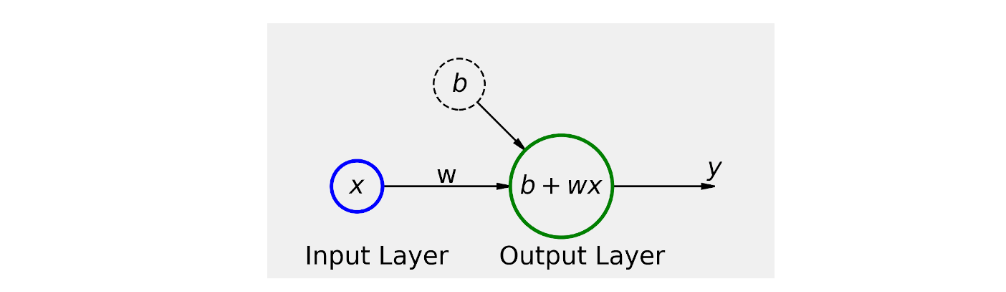

### 使用Numpy实现线性回归
现在是时候使用梯度下降和Numpy来实现我们的线性回归模型了。

如果我们想在1,000个周期内训练我们的模型，我们只需要增加一个循环。

In [6]:
import numpy as np
true_b = 1
true_w = 2
N = 100

# 数据生成
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# 使用前80个数据作为训练集
train_idx = idx[:int(N*.8)]
# 使用剩余20个数据作为验证集
val_idx = idx[int(N*.8):]

# 生成训练集和验证集
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

np.random.seed(42)
b = np.random.randn(1)                                    # 1)
w = np.random.randn(1)                                    # 1)

print("# b and w after initialization")
print(b, w)

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter 
lr = 0.1                                                  # 2)
# Defines number of epochs
n_epochs = 1000                                           # 2)

for epoch in range(n_epochs):
    # Step 1 - computes model's predicted output - forward pass
    yhat = b + w * x_train                                # 3)
    
    # Step 2 - computes the loss
    # We are using ALL data points, so this is BATCH gradient 
    # descent. How wrong is our model? That's the error! 
    error = (yhat - y_train)                              # 4)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()                            # 4)
    
    # Step 3 - computes gradients for both "b" and "w" parameters
    b_grad = 2 * error.mean()                             # 5)
    w_grad = 2 * (x_train * error).mean()                 # 5)
    
    # Step 4 - updates parameters using gradients and 
    # the learning rate
    b = b - lr * b_grad                                   # 6)
    w = w - lr * w_grad                                   # 6)

print("# b and w after our gradient descent")    
print(b, w)

# b and w after initialization
[0.49671415] [-0.1382643]
# b and w after our gradient descent
[1.02354094] [1.96896411]


以下是指上述代码中出现的过程步骤：
- 第0步：参数/权重的随机初始化（第3-4行）。
- 超参数的初始化（第10-12行）。
- 第1步：向前传递（第16行）。
- 第2步：计算损失（第21-23行）。
- 第3步：计算梯度（第26-27行）。
- 第4步：更新参数（第31-32行）。
下图显示了我们训练的模型的预测结果。

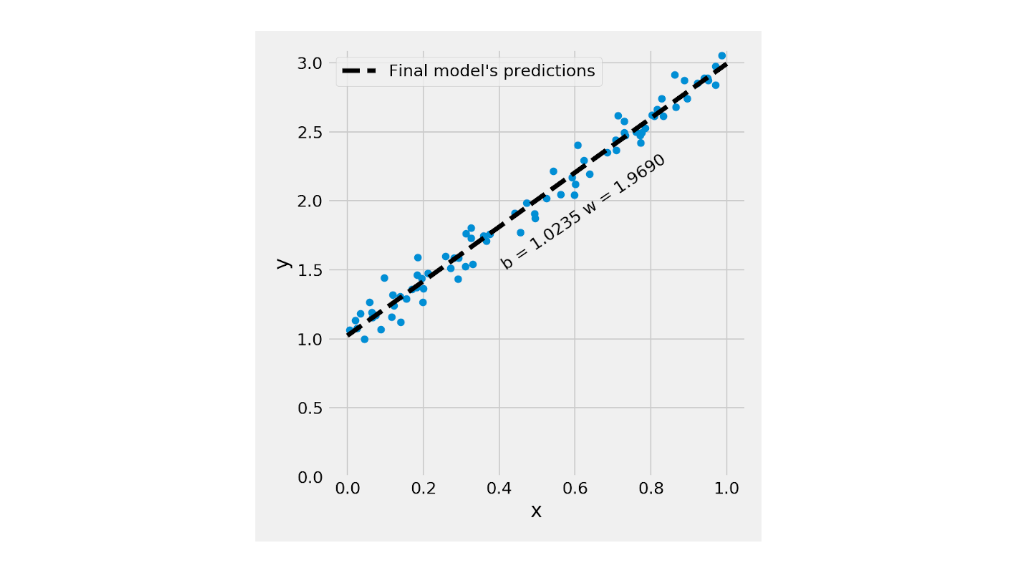

### 使用Scikit-Learn实现线性回归
为了确保我们的代码没有犯任何错误，我们可以使用Scikit-Learn的线性回归来拟合模型并比较系数。
scikit-learn要求X是一个特征矩阵，y是一个NumPy向量

In [7]:
from sklearn.linear_model import LinearRegression


linr = LinearRegression()#默认使用最小二乘法
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])#查看结果与之前是否相同

[1.02354075] [1.96896447]


## PyTorch张量（Tensors）
在PyTorch中，我们使用张量来表示数据。张量是一个多维数组，它可以存储任何类型的数据。张量的维度称为秩。张量的秩是它的维数。张量的形状是一个整数元组，它描述了每个维度中数组的大小。

在深度学习中，我们到处看到张量（Tensors）。好吧，谷歌的框架被称为TensorFlow是有原因的!张量到底是什么？

### 张量（Tensors）

在Numpy中，你可能有一个有三个维度的数组，对吗？从技术上讲，这就是一个张量。

标量（一个单一的数字）有零维，矢量有一维，矩阵有二维，而张量有三维或更多。这就是了!

但为了简单起见，人们通常也把向量和矩阵称为张量。所以，从现在开始，所有东西要么是标量，要么是张量。

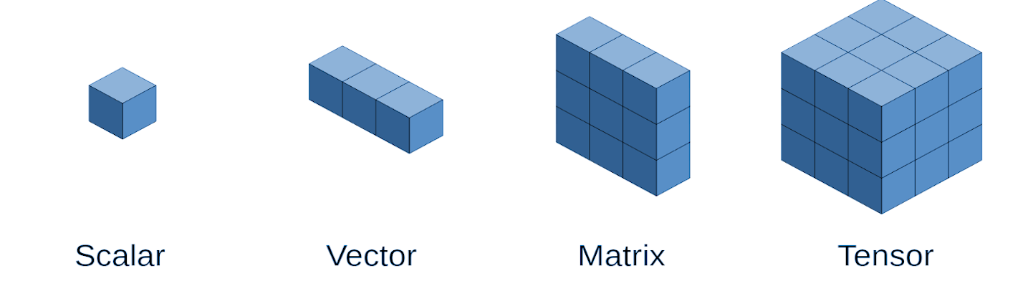

你可以在PyTorch中创建张量，与你在Numpy中创建数组的方式相同。使用tensor()，你可以创建一个标量或一个张量。

PyTorch中的张量与Numpy中的张量具有相同的功能，如： ones(), zeros(), rand(), randn()，等等。

在下面的例子中，我们分别创建了一个：标量、矢量、矩阵和张量。或者，换一种说法，一个标量和三个张量。


In [8]:
import torch

scalar = torch.tensor(3.14159)
vector = torch.tensor([1, 2, 3])
matrix = torch.ones((2, 3), dtype=torch.float)#第一参数是形状，第二个参数是数据类型
tensor = torch.randn((2, 3, 4), dtype=torch.float) #(2, 3, 4)表示2个3行4列的矩阵

print(scalar)
print(vector)
print(matrix)
print(tensor)

tensor(3.1416)
tensor([1, 2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[[ 0.6784, -1.2345, -0.0431, -1.6047],
         [ 1.7878, -0.4780, -0.2429, -0.9342],
         [-1.1109,  0.0915, -2.3169, -0.2168]],

        [[-1.3847, -0.8712, -0.2234,  1.7174],
         [-0.5920, -0.0631, -0.8286,  0.3309],
         [-1.5576,  0.9956, -0.8798, -0.6011]]])


你可以使用张量的size()方法或其shape属性获得张量的形状。

In [9]:
import torch
# creating a tensor and printing it's shape
tensor = torch.randn((2, 3, 4), dtype=torch.float)
print(tensor.size())
print(tensor.shape)

torch.Size([2, 3, 4])
torch.Size([2, 3, 4])


所有的张量都有形状，但标量有 "空 "的形状，因为它们是无维的（如果你愿意，也可以是零维）。

In [10]:
import torch

# creating a scalar and printing it's shape
scalar = torch.tensor(3.14159)
print(scalar.size(), scalar.shape)

torch.Size([]) torch.Size([])


你也可以使用张量的view()（首选）或reshape()方法对其进行**重塑**。

请注意:
- view()方法只返回一个具有所需形状的张量，它与原始张量共享基础数据；它不会创建一个新的、独立的张量!

- reshape()方法可能会也可能不会创建一个副本!这种（明显的）怪异行为背后的原因超出了本课的范围，但这种行为是view()被优先考虑的原因。

下面可以看到一个例子:

In [11]:
import torch

matrix = torch.ones((2, 3), dtype=torch.float)
# We get a tensor with a different shape but it still is the SAME tensor
same_matrix = matrix.view(1, 6)
# If we change one of its elements...
same_matrix[0, 1] = 2.
# It changes both variables: matrix and same_matrix
print(matrix)
print(same_matrix)

tensor([[1., 2., 1.],
        [1., 1., 1.]])
tensor([[1., 2., 1., 1., 1., 1.]])


如果你想真实地复制所有的数据，也就是说，在内存中复制数据，你可以使用它的new_tensor()或clone()方法。

In [12]:
import torch

matrix = torch.ones((2, 3), dtype=torch.float)
# 我们可以通过new_tensor()方法来创建一个新的tensor
different_matrix = matrix.new_tensor(matrix.view(1, 6))
# Now, if we change one of its elements...
different_matrix[0, 1] = 3.
# The original tensor (matrix) is left untouched!
# But we get a "warning" from PyTorch telling us 
# to use "clone()" instead!
print(matrix)
print(different_matrix)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 3., 1., 1., 1., 1.]])


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_22888/599084839.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  different_matrix = matrix.new_tensor(matrix.view(1, 6))


在上面的代码中，由于使用new_tensor()，你可能会得到一个UserWarning。

似乎PyTorch更倾向于我们使用**clone()和detach()**，而不是new_tensor()。这两种方法都能达到相同的效果，但下面的代码被认为更干净、更易读。

In [13]:
import torch

matrix = torch.ones((2, 3), dtype=torch.float)
# Lets follow PyTorch's suggestion and use "clone" method
another_matrix = matrix.view(1, 6).clone().detach()
# Again, if we change one of its elements...
another_matrix[0, 1] = 4.
# The original tensor (matrix) is left untouched!
print(matrix)
print(another_matrix)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 4., 1., 1., 1., 1.]])


## 加载数据、设备和CUDA
### Numpy和PyTorch之间的转换
现在是时候开始将我们的Numpy代码转换为PyTorch了。我们将从训练数据开始，也就是我们的x_train和y_train数组。
#### "as_tensor "方法
as_tensor方法保留了数组的类型，这在下面的代码中也可以看到。

In [14]:
# as_tensor 函数把numpy数组转换为tensor
x_train_tensor = torch.as_tensor(x_train)
print(x_train.dtype, x_train_tensor.dtype)

float64 torch.float64


你也可以很容易地把它投到一个不同的类型，比如低精度（32位）的浮点数，使用float()方法，它在内存中占用的空间会更少。

In [15]:
# Using float function to change data types 
x_train_tensor = torch.as_tensor(x_train)
float_tensor = x_train_tensor.float() # (going from float64 to float32) 
print(float_tensor.dtype)

torch.float32


**重要提示：**as_tensor()和from_numpy()都会返回一个与原始Numpy数组**共享基础数据的张量**。与我们在上一课中使用view()时的情况类似，如果你修改了原始的Numpy数组，你也就修改了相应的PyTorch张量，反之亦然。

In [16]:
import numpy as np
import torch

dummy_array = np.array([1, 2, 3])
dummy_tensor = torch.as_tensor(dummy_array)
# Modifies the numpy array
dummy_array[1] = 0
# Tensor gets modified too...
print(dummy_tensor)

tensor([1, 0, 3], dtype=torch.int32)


"我们需要as_tensor()做什么？为什么我们不能直接使用torch.tensor()？torch.tensor()总是做一个数据的拷贝，而不是与Numpy数组共享底层数据。

### numpy方法
你也可以执行相反的操作；即使用numpy()方法将PyTorch张量转换回Numpy数组。

In [17]:
import numpy as np
import torch

dummy_array = np.array([1, 2, 3])
dummy_tensor = torch.as_tensor(dummy_array)
# Modifies the numpy array
dummy_array[1] = 0
# Using numpy function to convert PyTorch tensor to Numpy array
print(dummy_tensor.numpy())

[1 0 3]


### GPU张量
到目前为止，我们只创建了CPU张量。这意味着什么呢？它意味着张量中的数据存储在计算机的主内存中，对其进行的任何操作都将由其CPU（中央处理器，例如，英特尔®酷睿™i7处理器）来处理。因此，尽管数据（从技术上讲）在内存中，但我们仍将这种张量称为CPU张量。

如果您有NVIDIA的显卡，您可以利用其GPU的力量来加速模型训练。PyTorch支持使用CUDA（计算统一设备架构）将这些GPU用于模型训练，这需要事先进行安装和配置。

如果你确实有一个GPU（并且你设法安装了CUDA），我们就可以在PyTorch中使用它了。但是，即使你没有GPU，你也应该在本节中坚持下去。为什么呢？首先，你可以使用谷歌Colab的免费GPU。第二，你应该始终让你的代码为GPU准备好，也就是说，如果有GPU的话，它应该自动在GPU中运行。

### GPU的可用性

下面的代码片段提供了一个使用cuda.is_available()方法的例子。

In [18]:
# checking if your device has GPU or not
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


因此，如果你没有GPU，你的设备被称为cpu。如果你有一个GPU，你的设备被称为cuda或cuda:0。重要的是，你的代码将能够始终使用适当的设备。

如果你正在使用别人的电脑，而你不知道它有多少个GPU或它们是哪个型号，你可以用cuda.device_count()和cuda.get_device_name()来计算。

In [19]:
import torch

n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce GTX 1050 Ti


在我们的案例中，不存在GPU，因此，在上面的代码中没有任何东西被打印出来。

### 变成GPU张量
现在只剩下一件事要做；把我们的张量变成GPU的张量。这就是**to()**的用处。它将一个张量发送到指定的设备上。

In [20]:
# 将张量转移到GPU上
gpu_tensor = torch.as_tensor(x_train).to(device)
print(gpu_tensor[0])

tensor([0.7713], device='cuda:0', dtype=torch.float64)


在上面的例子中，在打印的输出中没有设备信息，因为PyTorch只是假设了默认的（cpu）。

对于GPU用户来说，当使用to()时，你可能会看到类似以下的输出。

现在让我们把这一切放在一起，让我们的训练数据为PyTorch做好准备。

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
#float()函数将数据类型转换为float32，这样可以节省内存
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
#float()函数将数据类型转换为float32，这样可以节省内存
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
#float()函数将数据类型转换为float32，这样可以节省内存
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

因此，我们定义了一个设备，将两个Numpy数组转换为PyTorch的张量，将它们铸成浮点数，然后将它们发送到设备上。让我们看一下这些张量的类型。

In [24]:
# checking if your device has GPU or not
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more 
# useful since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


如果你比较两个变量的类型，你会得到你所期望的：第一个变量是numpy.ndarray，第二个变量是torch.Tensor。

但是x_train_tensor "住 "在哪里？它是CPU还是GPU的张量？你不能说，但如果你使用PyTorch的type()，它会显示它的位置：torch.FloatTensor，在这种情况下是一个CPU张量（如果使用GPU，其位置将是torch.cuda.

### 将GPU张量转回Numpy中
在使用GPU张量的时候，还有一件事需要注意。还记得numpy()吗？如果我们想把GPU张量转回Numpy数组怎么办？

让我们用numpy()方法来检查一下。

In [26]:
# converting GPU tensor back to numpy
back_to_numpy = x_train_tensor.numpy()
print(back_to_numpy.shape)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

对于CPU用户来说，它将很容易转换，没有任何问题。然而，对于GPU用户来说，会有一个错误。不幸的是，Numpy不能处理GPU的张量。你需要先用cpu()把它们变成CPU的张量。

In [ ]:
# converting GPU tensor to cpu first and then to numpy
back_to_numpy = x_train_tensor.cpu().numpy()
print(back_to_numpy.shape)

(80, 1)


所以为了避免这个错误，首先使用cpu()，然后使用numpy()，即使你使用的是CPU。它遵循to(device)的相同原则；你可以与其他可能使用GPU的人分享你的代码。

## 创建参数

### 需要梯度的张量
用于训练数据的张量与作为可训练参数/权重的张量的区别是什么？

后者需要计算其梯度，所以我们可以更新其值（也就是参数的值）。这就是**require_grad=True**参数的用处。它告诉PyTorch为我们计算梯度。

你可能很想为一个参数创建一个简单的张量，并在以后将其发送到你选择的设备上；这与我们的数据类似，对吗？没有那么快。

在接下来的几段中，你将看到四块代码，显示了创建参数的不同尝试。

前三个尝试是为了建立一个解决方案。第一个尝试只有在你不打算使用GPU的情况下才有效。第二种根本就不工作。第三种可以工作，但它太啰嗦了。

推荐的创建参数的方法是用Final。

#### First 尝试
下面的第一块代码为我们的参数创建了两个张量，包括梯度和所有的参数。但它们默认是CPU张量。千万不要忘记设置种子，以确保重现性，就像我们之前在使用Numpy时一样。PyTorch的对应方法是torch.manual_seed()。

In [ ]:
import torch

# FIRST
# Initializes parameters "b" and "w" randomly, ALMOST as we 
# did in Numpy since we want to apply gradient descent on 
# these parameters we need to set REQUIRES_GRAD = TRUE
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
w = torch.randn(1, requires_grad=True, dtype=torch.float)
print(b, w)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


#### Second 尝试
假设你想使用你的GPU（或来自Google Colab的GPU），我们需要将这些张量发送到设备上。我们可以尝试天真的方法，也就是把训练数据发送到设备上的那个方法，效果不错。这是我们的第二次（也是失败的）尝试。

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# SECOND
# But what if we want to run it on a GPU? We could just 
# send them to device, right?
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
w = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(b, w)
# Sorry, but NO! The to(device) "shadows" the gradient...

tensor([0.3367], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([0.1288], device='cuda:0', grad_fn=<ToCopyBackward0>)


我们成功地将它们发送到另一个设备上，但由于不再有require_grad=True（不要去管那个奇怪的grad_fn），我们就莫名其妙地失去了梯度（梯度消失）。很明显，我们需要做得更好。

 #### Third 尝试
在第三块中，我们首先将我们的张量发送到设备上，然后使用 requires_grad_() 方法将其 requires_grad 属性设置为 True。

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# THIRD
# We can either create regular tensors and send them to 
# the device (as we did with our data)
torch.manual_seed(42)
b = torch.randn(1, dtype=torch.float).to(device)
w = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
b.requires_grad_()
w.requires_grad_()
print(b, w)


tensor([0.3367], device='cuda:0', requires_grad=True) tensor([0.1288], device='cuda:0', requires_grad=True)


这种方法运行良好。我们设法为我们的参数b和w最终提供了需要梯度的GPU张量，但这似乎是一个很大的工作。我们还能做得更好吗？

#### Final 尝试
是的，我们可以做得更好。我们可以在创建张量的时候将其分配给一个设备。

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# FINAL
# We can specify the device at the moment of creation
# RECOMMENDED!

# Step 0 - initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
print(b, w)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


## Autograd
### Autograd简介
Autograd 是 PyTorch 的自动微分包。多亏了它，我们不需要担心偏导数、链式规则或类似的东西。那么，我们如何告诉 PyTorch 做它的事情并计算所有梯度呢？这就是 backward() 方法的作用。它将计算给定变量计算中涉及的所有（需要梯度的）张量的梯度。你还记得计算梯度的起点吗？这是损失，因为我们计算了它的偏导数 w.r.t。因此，我们需要从相应的 Python 变量： loss.backward() 调用 backward() 方法。

In [27]:

# Step 1 -前向传播计算模型的预测值
yhat = b + w * x_train_tensor

# Step 2 - 计算损失
# 使用批量梯度下降法，计算损失函数的梯度
# descent. How wrong is our model? That's the error! 
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# Step 3 -使用新的backward()方法计算梯度
# b_grad = 2 * error.mean()
# w_grad = 2 * (x_tensor * error).mean()   
loss.backward()                           # 1)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

### backward 处理的张量
在我们的示例中，哪些张量将由应用于 loss 的 backward() 方法处理？我们已将 requires_grad=True 设置为 b 和 w ，因此它们显然包含在列表中。我们使用它们来计算 yhat ，所以它也会进入列表。然后我们使用 yhat 来计算 error ，它也被添加到列表中。因此， backward 方法将处理以下内容：
- b
- w
- yhat
- error
你看到这里的模式了吗？如果列表中的张量用于计算另一个张量，则后者也将包含在列表中。跟踪这些依赖关系正是动态计算图所做的，我们很快就会看到。x_train_tensor 和 y_train_tensor 呢？它们也参与计算，但我们将它们创建为“不需要”梯度的张量，所以 backward() 不关心它们。

In [ ]:
# using requires_grad to check if the following tensor require gradients or not
print(error.requires_grad, yhat.requires_grad, \
      b.requires_grad, w.requires_grad)
print(y_train_tensor.requires_grad, x_train_tensor.requires_grad)

### grad 方法 
梯度的实际值如何？我们可以通过查看张量的 grad 属性来检查它们。如果您查看该方法的文档，它会清楚地说明梯度是累积的。这是什么意思？这意味着如果我们再次运行 backward 和 grad 标题下的代码，然后检查 grad 属性，我们将得到以下值：

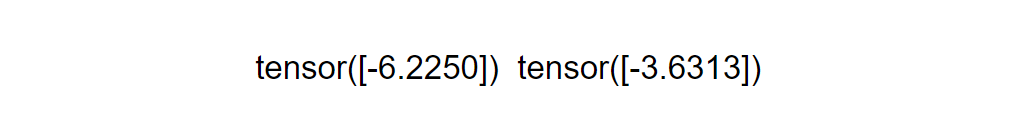

如果你有 GPU，你的输出会略有不同：

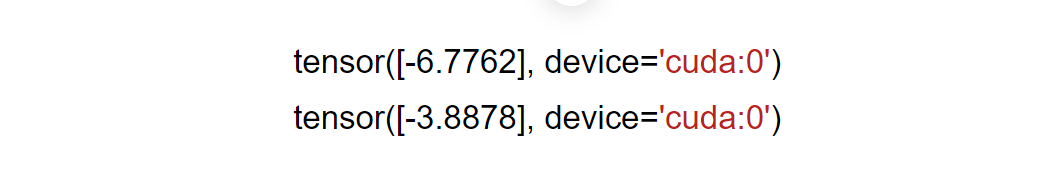

### 梯度累积 
正如预期的那样，这些梯度值恰好是之前的两倍。这是因为我们在每次迭代中都调用了 backward() 方法。这意味着我们在每次迭代中都计算了梯度，但是我们没有将其重置为零。因此，我们需要在每次迭代之前将其重置为零。我们可以使用 grad.zero_() 方法来实现这一点。

### zero_ 方法 
每次我们使用梯度来更新参数时，我们都需要在之后将梯度归零。这就是 zero_() 的好处。
```python
# This code will be placed _after_ step 4 
# (updating the parameters)
print(b.grad.zero_(), w.grad.zero_())
```
## 更新参数
### 更新参数的所有方法总结
#### 1.第一次尝试 
在第一次尝试中，如果我们使用与 Numpy 代码中相同的更新结构，我们会得到一个奇怪的错误，但我们可以通过查看张量本身来了解发生了什么。再一次，我们在将更新结果重新分配给我们的参数时“丢失”了梯度。因此， grad 属性变成了 None ，它引发了错误。

In [28]:
import torch 
lr = 0.1

torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

n_epochs = 1000
for epoch in range(n_epochs):
    yhat = b + w * x_train_tensor
    error = (yhat - y_train_tensor)
    loss = (error ** 2).mean()
    loss.backward()
    
    # Step 4 - updates parameters using gradients and
    # the learning rate. But not so fast...
    # FIRST ATTEMPT - just using the same code as before
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    b = b - lr * b.grad                          
    w = w - lr * w.grad                          
    print(b)                                     
    
    b.grad.zero_()                               
    w.grad.zero_()                               
    
print(b, w)

tensor([0.5328], device='cuda:0', grad_fn=<SubBackward0>)


e:\Anaconda3\lib\site-packages\torch\_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:475.)
  return self._grad


AttributeError: 'NoneType' object has no attribute 'zero_'

In [ ]:
lr = 0.1

torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

n_epochs = 1000
for epoch in range(n_epochs):
    yhat = b + w * x_train_tensor
    error = (yhat - y_train_tensor)
    loss = (error ** 2).mean()
    loss.backward()
    
    # Step 4 - updates parameters using gradients and
    # the learning rate. But not so fast...
    # FIRST ATTEMPT - just using the same code as before
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    b = b - lr * b.grad                          
    w = w - lr * w.grad                          
    print(b)                                     
    
    b.grad.zero_()                               
    w.grad.zero_()                               
    
print(b, w)

NameError: name 'torch' is not defined

GPU 用户可能会得到类似于以下内容的输出：

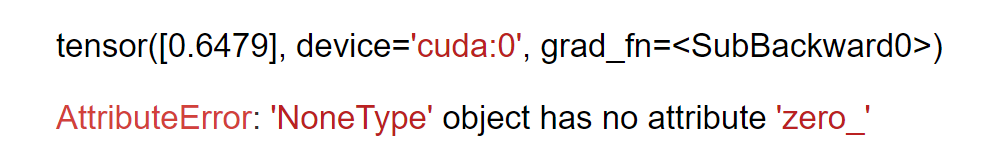

#### 2.第二次尝试 
然后，我们在第二次尝试中使用熟悉的就地 Python 赋值稍微更改它。而且，PyTorch 再次抱怨并引发错误。这次，我们得到了以下错误：

In [ ]:
lr = 0.1

torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

n_epochs = 1000
for epoch in range(n_epochs):
    yhat = b + w * x_train_tensor
    error = (yhat - y_train_tensor)
    loss = (error ** 2).mean()
    loss.backward()
    
    # SECOND ATTEMPT - using in-place Python assingment
    # RuntimeError: a leaf Variable that requires grad
    # has been used in an in-place operation.
    b -= lr * b.grad                             
    w -= lr * w.grad                             
    
    b.grad.zero_()                                
    w.grad.zero_()                                
    
print(b, w)

为什么？！事实证明这是一个“好事太多”的案例。罪魁祸首是 PyTorch 能够从涉及任何梯度计算张量或其依赖项的每个 Python 操作构建动态计算图。
#### 3.第三次尝试
**no_grad 方法**

那么，我们如何告诉 PyTorch “后退”并让我们在不破坏其花哨的动态计算图的情况下更新参数？这就是 torch.no_grad() 的用处。它允许我们在**不影响 PyTorch 计算图**的情况下对张量执行常规 Python 操作。使用它，我们最终成功地运行了我们的模型并获得了结果参数。果然，它们与我们在仅限 Numpy 的实现中获得的匹配。

In [29]:
lr = 0.1

torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

n_epochs = 1000
for epoch in range(n_epochs):
    yhat = b + w * x_train_tensor
    error = (yhat - y_train_tensor)
    loss = (error ** 2).mean()
    loss.backward()
        
    # THIRD ATTEMPT - NO_GRAD for the win!
    # We need to use NO_GRAD to keep the update out of 
    # the gradient computation. Why is that? It boils 
    # no_grad函数的作用是在反向传播的时候阻止梯度的传播，即不计算梯度
    with torch.no_grad():                          
        b -= lr * b.grad                           
        w -= lr * w.grad                           
    
    b.grad.zero_()                                 
    w.grad.zero_()                                 
    
print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


#### 总结
第一次尝试：导致 AttributeError （第 37-39 行）。
第二次尝试：导致 RuntimeError （第 44-45 行）。
第三次尝试： no_grad 解决了问题（第 51-53 行）！
zero_ 防止梯度累积（第 57-58 行）。

## 动态计算图
### 介绍
PyTorchViz 包及其 make_dot(variable) 方法使我们能够轻松地可视化与梯度计算中涉及的给定 Python 变量关联的图形。这是一个非常有用的工具，因为它允许我们在训练模型时查看模型的内部结构。我们可以使用它来查看我们的模型是否在预期的方式下工作，以及是否存在任何问题。
### 绘制张量图 
所以，让我们坚持最低限度；两个（梯度计算）张量用于我们的参数、预测、误差和损失。这些是步骤 0、1 和 2。

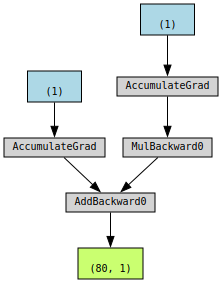

In [33]:
# Step 0 - initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Step 1 - computes our model's predicted output - forward pass
yhat = b + w * x_train_tensor

# Step 2 - computes the loss
error = (yhat - y_train_tensor)
loss = (error ** 2).mean()

# We can try plotting the graph for any python variable:
# yhat, error, loss...
make_dot(yhat)


让我们仔细看看它的组成部分：
- 蓝色框（ (1)s ）：这些框对应我们用作参数的张量；我们要求 PyTorch 计算梯度的那些。
- 灰色框（ MulBackward0 和 AddBackward0 ）：涉及梯度计算张量或其依赖项的 Python 操作。
- 绿框 ( (80, 1) )：张量用作梯度计算的起点，假设从用于可视化图形的变量调用 backward() 方法。它们是在图中自下而上计算的。

现在，仔细看看图表底部的灰色框；两个箭头指向它，因为它添加了 b 和 w*x 两个变量。看起来很明显，对吧？但是，这是 PyTorch 的动态计算图的一个重要特征。它们是在图中自下而上计算的，因此它们的顺序是相反的。这意味着，如果我们在图中添加一个新的变量，它将在图的顶部显示，而不是在底部。
然后，查看同一张图的灰色框（ MulBackward0 ）；它正在执行乘法，即 w*x 。但是只有一个箭头指向它！箭头来自与我们的参数 w 对应的蓝色框。有人就会问“为什么我们的数据没有一个盒子 ( x )？”因为：我们不为它计算梯度！因此，即使计算图执行的操作涉及更多的张量，它也仅显示梯度计算张量及其依赖关系。

如果我们将参数 b 的 requires_grad 设置为 False ，计算图会发生什么变化？

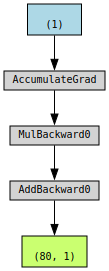

In [34]:
# setting the gradient to false for parameter b
b_nograd = torch.randn(1, requires_grad=False, \
                       dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

yhat = b_nograd + w * x_train_tensor

make_dot(yhat)

不出所料，参数 b 对应的蓝色框没有了！
### 复杂的动态计算图 
动态计算图的最大优点是您可以根据需要将其复杂化。您甚至可以使用控制流语句（例如， if 语句）来控制梯度流。下面的代码和图显示了一个例子。是的，我们确实知道计算本身完全是胡说八道。

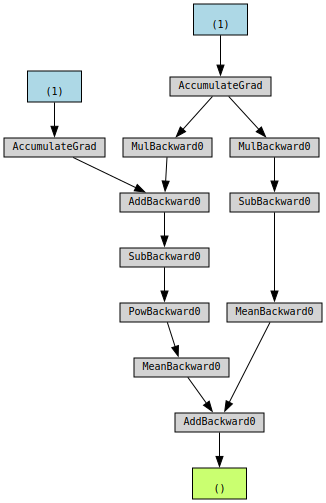

In [35]:
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

yhat = b + w * x_train_tensor
error = yhat - y_train_tensor
loss = (error ** 2).mean()

# this makes no sense!!
if loss > 0:
    yhat2 = w * x_train_tensor
    error2 = yhat2 - y_train_tensor
    
# neither does this :-)
loss += error2.mean()

make_dot(loss)

即使计算是无意义的，您也可以清楚地看到添加 if loss > 0 之类的控制流语句的效果。它将计算图分为两部分。右分支在 if 语句中执行计算，最后将其添加到左分支的结果中。很酷，对吧？尽管我们在本课程中没有像这样构建更复杂的模型，但这个小示例说明了 PyTorch 的功能以及它们在代码中的实现有多么容易。
## 优化器
到目前为止，我们一直在使用计算出的梯度手动更新参数。这对于两个参数来说可能没问题，但是如果我们有很多参数呢？我们需要使用 PyTorch 的优化器之一，如 SGD、RMSprop 或 Adam。有很多优化器； SGD 是其中最基本的，Adam 是最受欢迎的之一。不同的优化器使用不同的机制来更新参数，但它们都通过（字面上）不同的路径实现相同的目标。小批量大小的选择会影响梯度下降的路径，优化器的选择也会影响。

下面是一个示例，其中定义了 SGD 优化器：

In [36]:
#优化器的 第一个参数是需要优化的参数，第二个参数是学习率
optimizer = optim.SGD([b, w], lr=lr)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### step 和 zero_grad 方法 
优化器获取我们想要更新的参数、我们想要使用的学习率（以及可能还有许多其他超参数），并通过其 step() 方法执行更新。此外，我们也不再需要将梯度一个一个地归零了。我们只需调用优化器的 zero_grad() 方法，就是这样！在下面的代码中，我们创建了一个随机梯度下降 (SGD) 优化器来更新我们的参数 b 和 w 。不要被优化器的名字所迷惑。如果我们像在这段代码中实际做的那样一次使用所有训练数据进行更新，优化器将执行批量梯度下降，尽管它的名称。

In [ ]:
# 设置学习率
lr = 0.1

# Step 0 - 随机初始化 b 和 w
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# 使用SGD优化器来更新参数
optimizer = optim.SGD([b, w], lr=lr)               # 1)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error! 
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Backward方法计算梯度
    loss.backward()
    
    # Step 4 - 使用step方法更新参数
    # the learning rate. No more manual update!
    # with torch.no_grad():
    #     b -= lr * b.grad
    #     w -= lr * w.grad
    optimizer.step()                               # 2)
    
    # 不用再手动清零梯度，优化器会自动清零
    # b.grad.zero_()
    # w.grad.zero_()
    optimizer.zero_grad()                          # 3)
    
print(b, w)

## 损失函数
我们现在将处理损失计算过程。正如预期的那样，PyTorch 再次让我们受益匪浅。根据手头的任务，有许多损失函数可供选择。由于我们的是回归，我们使用均方误差 (MSE) 作为损失，因此我们需要 PyTorch 的 nn.MSELoss ：

In [37]:
import torch.nn as nn#引入nn模块

# 使用nn.MSELoss()来计算损失，reduction='mean'表示计算平均损失
loss_fn = nn.MSELoss(reduction='mean')
print(loss_fn)

MSELoss()


请注意， nn.MSELoss **不是损失函数本身**。我们不会将预测和标签传递给它！相反，如您所见，它返回另一个函数，我们称之为 **loss_fn** 。这就是实际的损失函数。所以，我们可以给它传递一个预测和一个标签，并得到相应的损失值：

In [38]:
import torch
import torch.nn as nn

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# This is a random example to illustrate the loss function
predictions = torch.tensor([0.5, 1.0])
labels = torch.tensor([2.0, 1.3])
print(loss_fn(predictions, labels))

tensor(1.1700)


此外，您还可以指定要应用的缩减方法。您希望如何汇总各个点的错误？您可以对它们进行平均 ( reduction="mean" ) 或简单地对它们求和 ( reduction="sum" )。在我们的示例中，我们使用典型的 mean 缩减来计算 MSE。如果我们使用 sum 作为归约，我们实际上会计算 SSE（误差平方和）从技术上讲， nn.MSELoss 是一个高阶函数。
### 使用创建的损失函数 
然后，我们在下面的代码和第 29 行中使用创建的损失函数来计算损失，给定我们的预测和我们的标签：

In [39]:
# Sets learning rate - this is "eta" ~ the "n" like
# Greek letter
lr = 0.1

# Step 0 - initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')             # 1)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 -利用创建的损失函数来计算损失
    # 相当于 error = (yhat - y_train_tensor)、loss = (error ** 2).mean()
    loss = loss_fn(yhat, y_train_tensor)           # 2)

    # Step 3 - computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - updates parameters using gradients and 
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    
print(b, w)
print(loss) # printing the MSE loss value

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)
tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)


### 将损失张量转换为 Numpy 数组 
如果我们想将它作为 Numpy 数组怎么办？我们可以再次使用 numpy() ，对吗？ （并且也使用 cpu() ，因为我们的损失在 cuda 设备中。）这是一个好主意，但是我们可以做得更好。我们可以使用 .item() 方法来获取损失张量中的单个值。这是一个 Python 数字，而不是一个张量。这是因为我们的损失是一个标量，而不是一个向量或矩阵。因此，它只包含一个值，而不是一个张量。这是一个很好的习惯，因为它可以避免一些错误。在下面的代码中，我们使用 .item() 来获取损失值：


In [40]:
loss.cpu().numpy() # converting to numpy

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

这里发生了什么？与我们的数据张量不同，损失张量实际上是在计算梯度。要使用 numpy() ，我们首先需要 detach() 计算图中的张量：

In [41]:
# converting to numpy using detach since gradient is being computed
print(loss.detach().cpu().numpy())

0.008044655


我们可以对具有单个元素的张量使用 item() ，多个元素使用 tolist() （如果只有一个元素，它仍然返回一个标量）。

In [43]:
#使用item()来获取标量值
print(loss.item(), loss.tolist())

0.008044655434787273 0.008044655434787273


## Moudle
在 PyTorch 中，模型由继承自 Module 类的常规 Python 类表示。模型类需要实现的最基本方法是：
- __init__(self) ：它定义了组成模型的部分；在我们的例子中，有两个参数 b 和 w 。但是，您不仅限于定义参数。模型也可以包含其他模型作为它们的属性，因此您可以轻松地嵌套它们。我们很快也会看到这样的例子。此外，不要忘记包含 super().__init__() 以在您自己的之前执行父类（ nn.Module ）的 __init__() 方法。

- forward(self, x) ：它执行实际的计算；也就是说，它在给定输入 x 的情况下输出预测。这可能看起来很奇怪，但无论何时使用模型进行预测，都不应该调用 forward(x) 方法！您应该改为调用整个模型（如在 model(x) 中）来执行前向传递和输出预测。这样做的原因是因为对整个模型的调用涉及额外的步骤，即处理前向和后向hooks。如果您不使用hooks（我们现在不使用任何hooks），那么这两个调用是等价的。hooks是一种非常有用的机制，它允许在更深层次的模型中检索中间值。它们超出了本课程的范围。

让我们为回归任务构建一个合适的（但简单的）模型。它应该是这样的：

In [44]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        #这里为什么要调用父类的构造函数呢？因为nn.Module是一个基类，我们需要调用它的构造函数来初始化一些参数
        super().__init__()
        # 让b和w成为模型的参数，
        # 我们需要把他们包装成nn.Parameter
        self.b = nn.Parameter(torch.randn(1, 
                                          requires_grad=True, 
                                          dtype=torch.float))
        #torch.randn(1)第一个参数表示生成的张量的形状，这里生成的是一个标量                            
        self.w = nn.Parameter(torch.randn(1, 
                                          requires_grad=True,
                                          dtype=torch.float))
    # 定义前向传播    
    def forward(self, x):
        #计算yhat = b + w * x
        return self.b + self.w * x

###  Parameter 和 parameters 方法 
在 __init__ 方法中，我们使用 Parameter() 类定义了两个参数 b 和 w ，以告诉 PyTorch 这些张量是 ManualLinearRegression 类的属性，应该被视为该类代表的模型。我们为什么要关心这个？通过这样做，我们可以使用我们模型的 parameters() 方法来检索所有模型参数的迭代器，包括嵌套模型的参数。然后我们可以使用它来为我们的优化器提供数据（而不是我们自己构建一个参数列表）。

In [45]:
torch.manual_seed(42)
# Creates a "dummy" instance of our ManualLinearRegression model
dummy = ManualLinearRegression()
print(list(dummy.parameters()))

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]


### state_dict 方法
此外，我们可以使用模型的 state_dict() 方法获取所有参数的当前值。


In [46]:
dummy = ManualLinearRegression()
print(dummy.state_dict())

OrderedDict([('b', tensor([0.2345])), ('w', tensor([0.2303]))])


给定模型的 state_dict() 只是一个 Python 字典，它将每个属性/参数映射到其对应的张量。但是只包括可学习的参数，因为它的目的是跟踪优化器将要更新的参数。让我们快速浏览一下 SGD 优化器的 state_dict() ：

In [47]:
# Defines a SGD optimizer
optimizer = optim.SGD([b, w], lr=lr)
print(optimizer.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'params': [0, 1]}]}


### 前向传递
前向传递是模型进行预测。请记住：您应该调用 model(x) 进行预测，而不是model.forward(x) ！否则，您模型的挂钩将无法工作（如果您有的话）。我们可以使用所有这些方便的方法来更改我们的代码，它应该如下所示：

In [48]:
# Sets learning rate - this is "eta" ~ the "n" like 
# Greek letter
lr = 0.1

# Step 0 - initializes parameters "b" and "w" randomly
torch.manual_seed(42)
#我们创建一个模型的实例，然后把它传递给设备
model = ManualLinearRegression().to(device)        # 1)

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    model.train() # What is this?                # 2)

    # Step 1 - computes model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)                   # 3)
    
    # Step 2 - computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    
# We can also inspect its parameters using its state_dict
print(model.state_dict())

OrderedDict([('b', tensor([1.0235], device='cuda:0')), ('w', tensor([1.9690], device='cuda:0'))])


查看我们的输出，参数 b 和 w 的最终值仍然相同，所以一切正常！
###  train方法
我希望您注意到上面代码（第 21 行）中的一个特定语句，我为其分配了一条注释：“这是什么？”声明是 model.train() 。
在 PyTorch 中，模型有一个 train() 方法，它不执行训练步骤。它的唯一目的是将模型设置为训练模式。为什么这很重要？例如，某些模型可能会使用像 Dropout 这样的机制，这些机制在训练和评估阶段具有不同的行为。
在训练循环中调用 model.train() 是一种很好的做法。也可以将模型设置为评估模式，但这是下一章的主题。
## 模型类型
### 嵌套模型 
在我们的模型中，我们手动创建了两个参数来执行线性回归。如果我们使用 PyTorch 的 Linear 模型而不是定义单独的参数会怎样？我们正在实现一个单一的特征线性回归，一个输入和一个输出，所以相应的线性模型看起来是这样的

In [51]:
import torch.nn as nn

linear = nn.Linear(1, 1)
print(linear)

Linear(in_features=1, out_features=1, bias=True)


我们还有 b 和 w 参数吗？我们当然知道！

In [52]:
import torch.nn as nn

linear = nn.Linear(1, 1)
print(linear.state_dict())

OrderedDict([('weight', tensor([[-0.4869]])), ('bias', tensor([0.5873]))])


所以，我们之前的参数 b 是偏置，我们之前的参数 w 是权重。您的值将有所不同，因为尚未为此示例设置随机种子。
现在，让我们使用 PyTorch 的 Linear 模型作为我们自己的属性，从而创建一个嵌套模型但是，您不仅限于定义参数。模型也可以包含其他模型作为它们的属性，因此您可以轻松地嵌套它们。我们很快就会看到这样的例子。

尽管这显然是一个人为的示例，并且由于我们几乎没有添加任何有用的（或根本没有）它来包装底层模型，它很好地说明了这个概念。

In [53]:
class MyLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear model 
        # with a single input and a single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call
        self.linear(x)

在 __init__ 方法中，我们创建了一个包含嵌套的 Linear 模型的属性。在 forward() 方法中，我们调用嵌套模型本身来执行正向传播（注意我们没有调用 self.linear.forward(x) ）。

现在，如果我们调用这个模型的 parameters() 方法，PyTorch 将递归计算其属性的参数。

In [54]:
torch.manual_seed(42)
# creating dummy instance of our MyLinearRegression model
dummy = MyLinearRegression().to(device)
print(list(dummy.parameters()))

[Parameter containing:
tensor([[0.7645]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.8300], device='cuda:0', requires_grad=True)]


您还可以添加额外的 Linear 属性，即使您根本不在正向传递中使用它们，它们仍会列在 parameters() 下。如果您愿意，还可以使用 state_dict() 来获取参数值及其名称：

In [55]:
# creating dummy instance of our MyLinearRegression model
dummy = MyLinearRegression().to(device)
print(dummy.state_dict())

OrderedDict([('linear.weight', tensor([[-0.2343]], device='cuda:0')), ('linear.bias', tensor([0.9186], device='cuda:0'))])


请注意，偏差和权重都有一个带有属性名称的前缀：linear。这是来自 __init__ 方法中的 self.linear 。
###  顺序模型 
我们的模型很简单。你可能会想：“为什么还要费心为它建立一个类呢？”嗯，你说得有道理。对于使用一系列内置 PyTorch 模型（如 Linear ）的简单模型，其中一个模型的输出按顺序作为输入馈送到下一个模型，我们可以使用 Sequential 模型。

在我们的例子中，我们将构建一个带有单个参数的 Sequential 模型；也就是说，我们用来训练线性回归的 Linear 模型。该模型看起来像这样：

In [59]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
#Sequential模块可以把多个模块组合成一个大的模块
model = nn.Sequential(nn.Linear(1, 1)).to(device)
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
#float()函数将数据类型转换为float32，这样可以节省内存
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
#float()函数将数据类型转换为float32，这样可以节省内存
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
#float()函数将数据类型转换为float32，这样可以节省内存
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
#float()函数将数据类型转换为float32，这样可以节省内存
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [60]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
#linear(2,2)表示输入的特征数为2，输出的特征数为2，权重w的形状为(2,2)，偏置b的形状为(2,)
model = nn.Sequential(nn.Linear(2, 2)).to(device)
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496]], device='cuda:0')), ('0.bias', tensor([-0.1549,  0.1427], device='cuda:0'))])


## Layers
Linear 模型可以看作是神经网络中的一层。

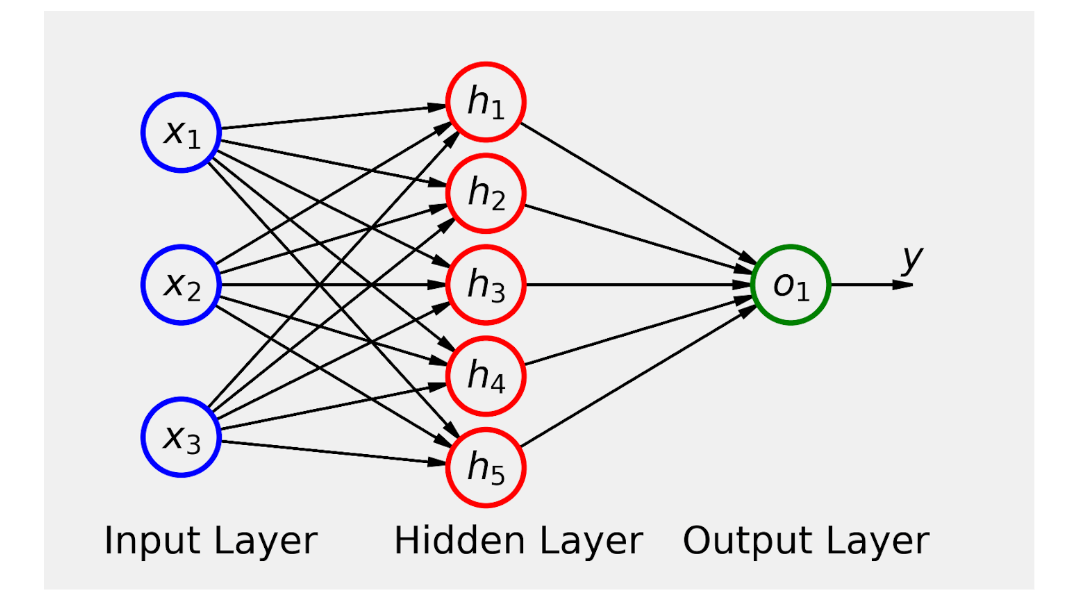

在上面的示例中，隐藏层将是 nn.Linear(3, 5) （因为它从输入层获取 3 个输入，并生成 5 个输出），输出层将是 nn.Linear(5, 1) （因为它从输入层获取 5 个输入，输出隐藏层，并生成单个输出）。如果我们使用 Sequential 来构建它，它看起来像这样：

In [61]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
# Building the model from the figure above
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165],
        [-0.2811,  0.3391,  0.5090],
        [-0.4236,  0.5018,  0.1081],
        [ 0.4266,  0.0782,  0.2784]], device='cuda:0')), ('0.bias', tensor([-0.0815,  0.4451,  0.0853, -0.2695,  0.1472], device='cuda:0')), ('1.weight', tensor([[-0.2060, -0.0524, -0.1816,  0.2967, -0.3530]], device='cuda:0')), ('1.bias', tensor([-0.2062], device='cuda:0'))])


由于此顺序模型没有属性名称,state_dict() 使用数字前缀。您还可以使用模型的 add_module() 方法来命名图层：

In [62]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
# 使用add_module()方法添加模块
model = nn.Sequential()
model.add_module('layer1', nn.Linear(3, 5))
model.add_module('layer2', nn.Linear(5, 1))
print(model.to(device))

Sequential(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)


### 图层类型 
PyTorch 中可以使用许多不同的层；下面提到了其中一些：
- Convolution layers 卷积层

- Pooling layers  池化层

- Padding layers  填充层

- Non-linear activations  非线性激活

- Normalization layers  归一化层

- Recurrent layers  循环层

- Transformer layers  变压器层

- Linear layers 线性层

- Dropout layers 丢弃层

- Sparse layers (embeddings)  稀疏层（嵌入）

- Vision layers  视觉层

- DataParallel layers (多 GPU)

- Flatten layer  展平层
到目前为止，我们只使用了一个 Linear 层。我们将在后面的章节中使用其他一些。

## 模型整合
### 使用 PyTorch 完成线性回归步骤 
到目前为止，我们已经涵盖了很多内容。从使用梯度下降在 Numpy 中编写线性回归，到将其转换为 PyTorch 模型，这一切都是一步一步完成的。现在是时候把它们放在一起并将我们的代码组织成三个基本部分，即：
- 数据准备
- 参数配置
- 模型训练

### 参数配置
我们已经看到了很多这部分；从手动定义参数 b 和 w ，然后使用 Module 类将它们包装起来，再到在 Sequential 模型中使用层。我们还为特定的线性回归模型定义了损失函数和优化器。为了组织我们的代码，我们将在模型配置部分包含以下元素：
- 一个模型
- 一个损失函数（需要根据你的模型来选择）
- 一个优化器（虽然有些人可能不同意这个选择，但它更容易进一步组织代码。）

In [65]:

# This is redundant now, but it won't be when we introduce 
# Datasets...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

### 模型训练
这是进行实际培训的最后一部分。它循环我们在本章开头看到的梯度下降步骤：
- 第 1 步：计算模型的预测
- 第 2 步：计算损失
- 第 3 步：计算梯度
- 第 4 步：更新参数
一遍又一遍地重复这个序列，直到达到 epoch 的数量。

In [66]:


# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - computes model's predicted output - forward pass
    yhat = model(x_train_tensor)
    
    # Step 2 - computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    # printing the parameter values of the Linear model
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])
